1. Relevant images per day

- Anomalous images are in csv
- Non-Anomlaous images are 
    a) not in csv
    b) date is equal 
    c) Modul number is not in csv

2. cv per day per reconstructer
    - n_sg: 24, 48, 96
    - n_comp: 20, 35, 50

    - Abs Threshold based on 90% quantile of the 0.05% quantiles of cv

3. SD Threshold?

4. Error growth filter?

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cv2

In [2]:
error_files = pd.read_csv('D:\\Indas\\MarkedErrors.csv')
error_files.head()

,Unnamed: 0,name,row_min,row_max,col_min,col_max
0,0,3137.232.529_2022.02.06_10014_004_new set.248_...,911,944,1439,1472
1,1,3137.232.529_2022.02.06_10037_004_new set.341_...,975,1008,1503,1536
2,2,3137.232.529_2022.02.06_10061_004_new set.20_F...,911,944,1711,1760
3,3,3137.232.529_2022.02.06_10070_004_new set.56_F...,815,864,1247,1280
4,4,3137.232.529_2022.02.06_10107_004_new set.205_...,991,1040,1663,1712


In [3]:
MarkedErrors_WithTitleInfo = error_files['name'].str.split('_', expand = True).rename(columns = {0: 'Code_A',  
                                                                                   1: 'Date',
                                                                                   2: 'Code_B',
                                                                                   3: 'Angle',
                                                                                   4: 'Set',
                                                                                   5: 'Res'})
MarkedErrors_WithTitleInfo['Date'] = pd.to_datetime(MarkedErrors_WithTitleInfo['Date'])
MarkedErrors_WithTitleInfo = pd.concat([MarkedErrors_WithTitleInfo, error_files], axis = 1).drop('Unnamed: 0', axis = 1)
MarkedErrors_WithTitleInfo.drop(['Set', 'Res'], axis = 1, inplace =True)
MarkedErrors_WithTitleInfo = MarkedErrors_WithTitleInfo.iloc[MarkedErrors_WithTitleInfo.Code_B.drop_duplicates().index.values]

In [4]:
from os import listdir
from os.path import isfile, join
my_path = 'D:\\Indas\\Preprocessed\\Preprocessed\\NOK_samples_xray\\004'
# image_list_test = [cv2.imread( my_path + img_name, cv2.IMREAD_REDUCED_GRAYSCALE_4).astype('float32')  for  img_name in  onlyfiles[400: 500]]
onlyfiles_test = [f for f in listdir(my_path) if isfile(join(my_path, f))]

In [5]:
file_names = pd.DataFrame({'name' : onlyfiles_test})['name'].str.split('_', expand = True).rename(columns = {0: 'Code_A',  
                                                                                   1: 'Date',
                                                                                   2: 'Code_B',
                                                                                   3: 'Angle',
                                                                                   4: 'Set',
                                                                                   5: 'Res'})
file_names['name']  = onlyfiles_test
file_names['Date'] = pd.to_datetime(file_names['Date'])

In [6]:
date_in =  [file_names.Date[i] in MarkedErrors_WithTitleInfo.Date.unique() for i in range(file_names.shape[0])]
codeB_in = [file_names.Code_B[i] in MarkedErrors_WithTitleInfo.Code_B.unique()  for i in range(file_names.shape[0])]
bin_idx_good = np.logical_and(np.array(codeB_in).__invert__(), np.array(date_in)) # TRAIN GOOD
bin_idx_good_0206 = np.logical_and(bin_idx_good, file_names['Date'] == dt.datetime(2022, 2, 6) )
bin_idx_good_0207 = np.logical_and(bin_idx_good, file_names['Date'] == dt.datetime(2022, 2, 7) )

In [7]:
img_array_ok_0206 = np.array([cv2.imread( my_path + '\\' + img_name, cv2.IMREAD_GRAYSCALE) for  img_name in file_names['name'][bin_idx_good_0206]])

In [8]:
img_array_nok_0206 = np.array([cv2.imread( my_path + '\\' + img_name, cv2.IMREAD_GRAYSCALE) for  img_name in MarkedErrors_WithTitleInfo['name'][MarkedErrors_WithTitleInfo.Date == dt.datetime(2022, 2, 6)]])

In [9]:
exec(open('D:\\Indas\\INDAS_FINAL\\Reconstructer_Classes.py').read())
exec(open('D:\\Indas\\INDAS_FINAL\\HelperFunctions.py').read())

In [58]:
for i in range(100):
    tmp = create_artificial_anomaly(img_array_ok_0206[0, :, :])

In [17]:
res = []
for i in range(10):
    res.append(k_fold_art_cv('row', 5, img_array_ok_0206, 24, 50))

In [19]:
[r[0] for r in res]

[0.026924541895251536,
 0.0405349877268853,
 0.03244705875405499,
 0.02485197666270363,
 0.033184815119921815,
 0.025119317310846045,
 0.03117938214544424,
 0.03376118165366062,
 0.02795542721490956,
 0.027142880342591175]

That seem quite stable!

In [11]:
k_fold_para_selection('row', 5, img_array_ok_0206, [48, 96], [30, 50])

[(48, 50),
 ([0.16812323040115687,
   0.11469912206429415,
   0.16219235321767325,
   0.10485495305522083],
  [24, 24, 48, 48],
  [30, 50, 30, 50])]

In [21]:
rowRecon_cv_res_0206 = k_fold_para_selection('row', 5, img_array_ok_0206, [24, 48, 96], [35, 50, 65])
rowRecon_cv_res_0206

[(96, 50),
 ([0.05552121697673091,
   0.04675747948419658,
   0.029889094510925075,
   0.05072183841074985,
   0.047235312180747724,
   0.033096593984799604,
   0.034783483805944954,
   0.030604343513702444,
   0.025029280631477416],
  [24, 24, 24, 48, 48, 48, 96, 96, 96],
  [20, 35, 50, 20, 35, 50, 20, 35, 50])]

dist_err_in_anomaly lowest 05-quantile 

In [38]:
rowRecon_cv_res_0206 = k_fold_para_selection('row', 5, img_array_ok_0206, [96, 144], [35, 50, 65])
rowRecon_cv_res_0206

[(144, 65),
 ([0.029721792175300358,
   0.02140006111912965,
   0.021748973046499944,
   0.022893101878621605,
   0.020073166914854144,
   0.019018422720633685],
  [96, 96, 96, 144, 144, 144],
  [35, 50, 65, 35, 50, 65])]

In [115]:
colRecon_cv_res_0206 = k_fold_para_selection('col', 5, img_array_ok_0206, [48, 96, 144], [35, 50, 65])

In [116]:
colRecon_cv_res_0206

[(96, 35),
 ([0.04749439373890005,
   0.0527685969122108,
   0.08790038266661943,
   0.03915226721008386,
   0.08245654095317584,
   0.06707105224565883,
   0.04128850305524539,
   0.056985472327739484,
   0.05966483053172457],
  [48, 48, 48, 96, 96, 96, 144, 144, 144],
  [35, 50, 65, 35, 50, 65, 35, 50, 65])]

In [171]:
subRecon_cv_res_0206 = k_fold_para_selection('sub', 5, img_array_ok_0206, [12, 24, 48], [10, 18, 25])

In [172]:
subRecon_cv_res_0206

[(24, 25),
 ([0.04572304229433083,
   0.03217848701566801,
   0.023824861139748996,
   0.03683668294660984,
   0.02710863828870016,
   0.02326551893748233,
   0.02952735465157766,
   0.03017987704731476,
   0.06010499514294122],
  [12, 12, 12, 24, 24, 24, 48, 48, 48],
  [10, 18, 25, 10, 18, 25, 10, 18, 25])]

In [130]:
rRecon = rowRecon(144, 65)
rRecon.fit(img_array_ok_0206[0:20])
cRecon = colRecon(96, 35)
cRecon.fit(img_array_ok_0206[0:20])

In [173]:
sRecon = subRecon(24, 25)
sRecon.fit(img_array_ok_0206[0:20])

In [125]:
img_array_ok_0206.shape

(21, 2016, 2016)

In [136]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]

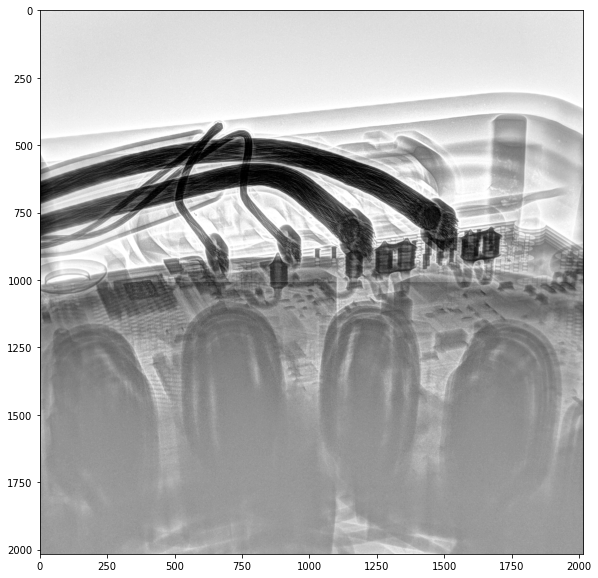

In [140]:
plt.imshow(img_array_nok_0206[2, :, :], cmap = 'gray')

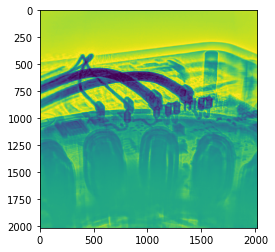

In [131]:
plt.imshow(rRecon.reconstruct(img_array_ok_0206[20, :, :]))

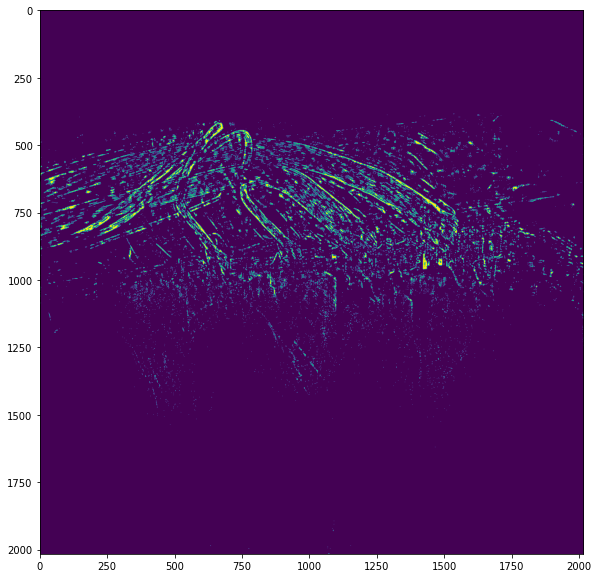

In [141]:
rowReconErr = (rRecon.reconstruct(img_array_nok_0206[2, :, :]) - img_array_nok_0206[2, :, :] )> 20
plt.imshow(rowReconErr)

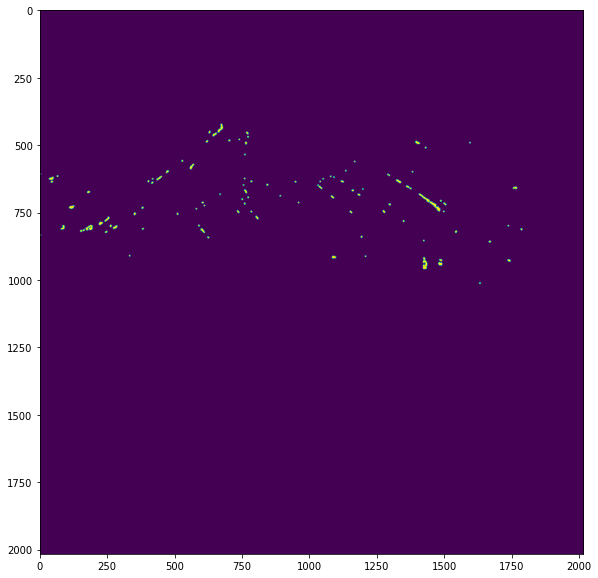

In [146]:
footprint = disk(3)
row_opened_error_map = morphology.binary_opening(image = rowReconErr, footprint = footprint)
plt.imshow(row_closed_error_map)                    

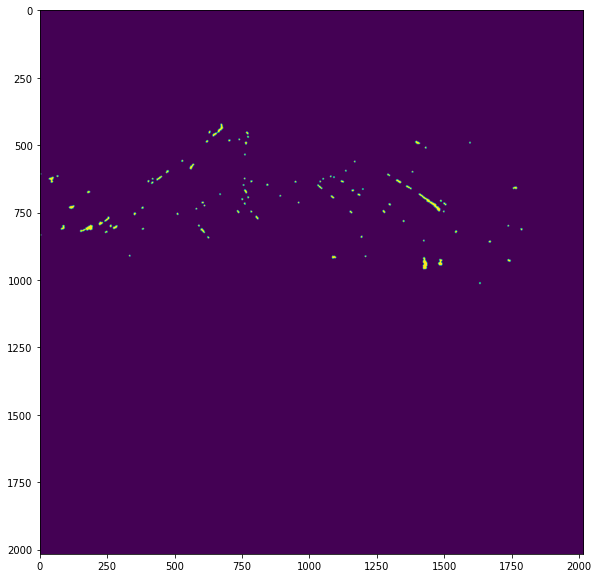

In [147]:
footprint = disk(3)
row_closed_error_map = morphology.binary_closing(image = row_opened_error_map, footprint = footprint)
plt.imshow(row_closed_error_map)         

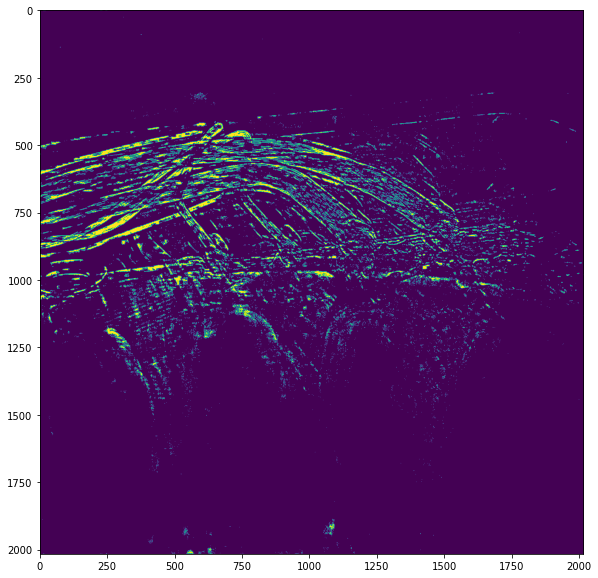

In [144]:
colReconErr = (cRecon.reconstruct(img_array_nok_0206[2, :, :]) - img_array_nok_0206[2, :, :] )> 20
plt.imshow(colReconErr)

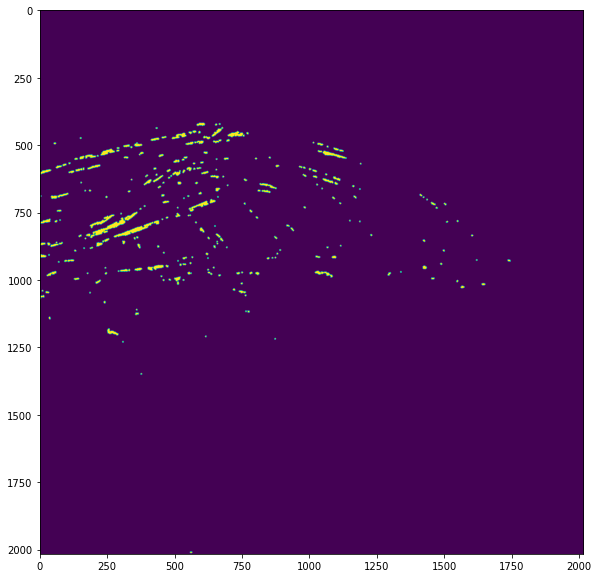

In [148]:
footprint = disk(3)
col_opened_error_map = morphology.binary_opening(image = colReconErr, footprint = footprint)
plt.imshow(col_opened_error_map)                    

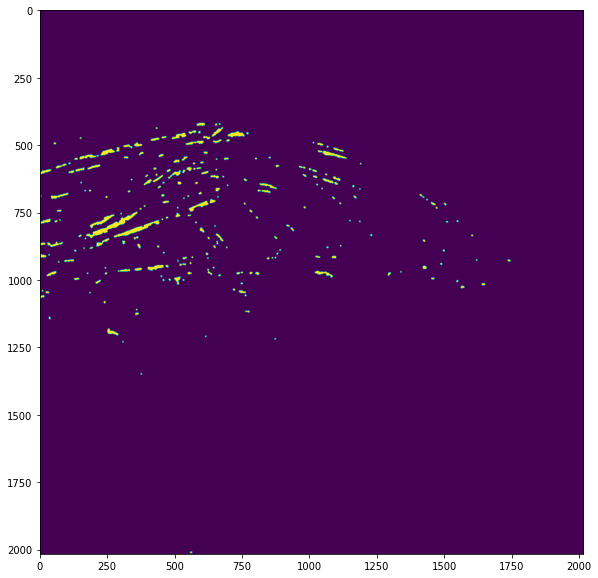

In [149]:
footprint = disk(3)
col_closed_error_map = morphology.binary_closing(image = col_opened_error_map, footprint = footprint)
plt.imshow(col_closed_error_map)         

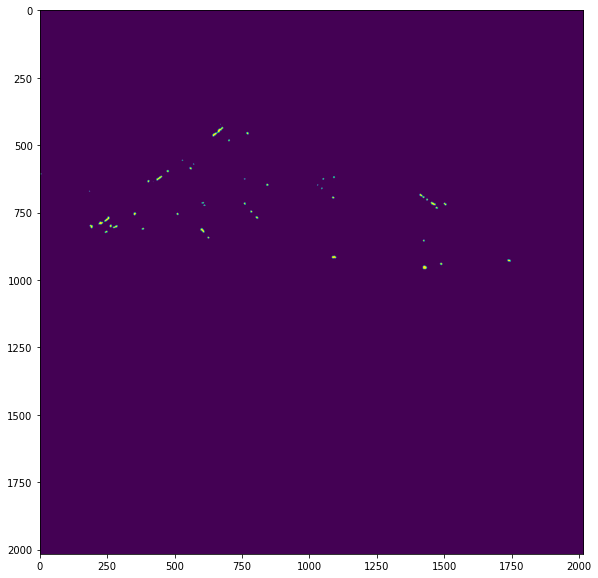

In [154]:
mer_err_map = np.minimum(col_closed_error_map, row_closed_error_map).astype('int')
plt.imshow(mer_err_map)

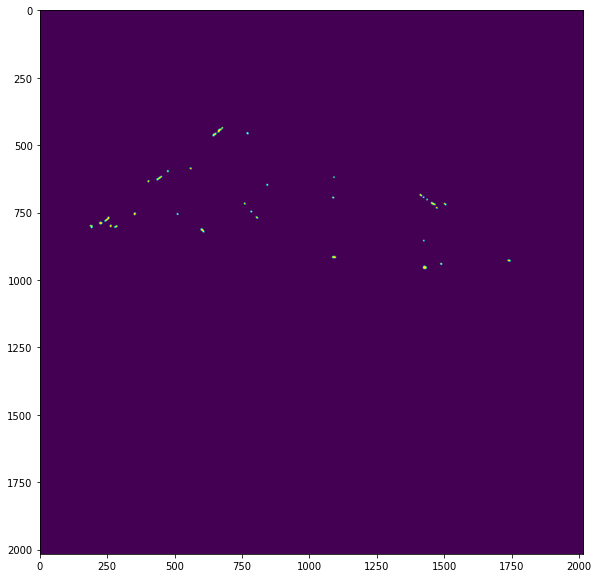

In [156]:
footprint = disk(3)
mer_opened_error_map = morphology.binary_opening(image = mer_err_map, footprint = footprint)
plt.imshow(mer_opened_error_map)                    

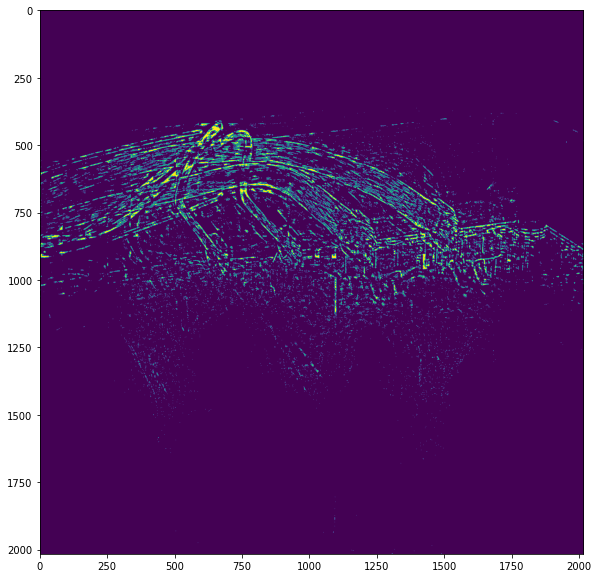

In [174]:
subReconErr = (sRecon.reconstruct(img_array_nok_0206[2, :, :]) - img_array_nok_0206[2, :, :] )> 20
plt.imshow(subReconErr)

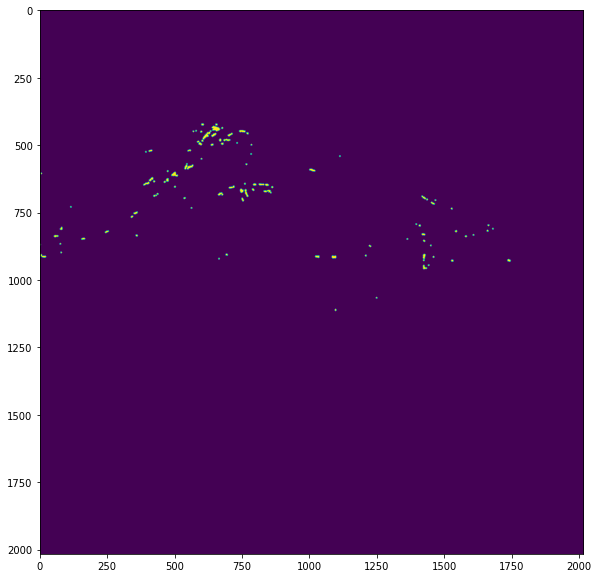

In [175]:
footprint = disk(3)
sub_opened_error_map = morphology.binary_opening(image = subReconErr, footprint = footprint)
plt.imshow(sub_opened_error_map)                    

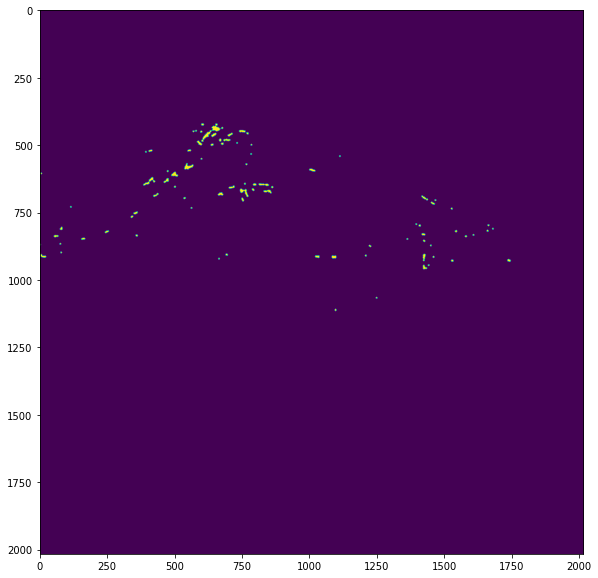

In [176]:
footprint = disk(3)
sub_closed_error_map = morphology.binary_closing(image = sub_opened_error_map, footprint = footprint)
plt.imshow(sub_closed_error_map)         

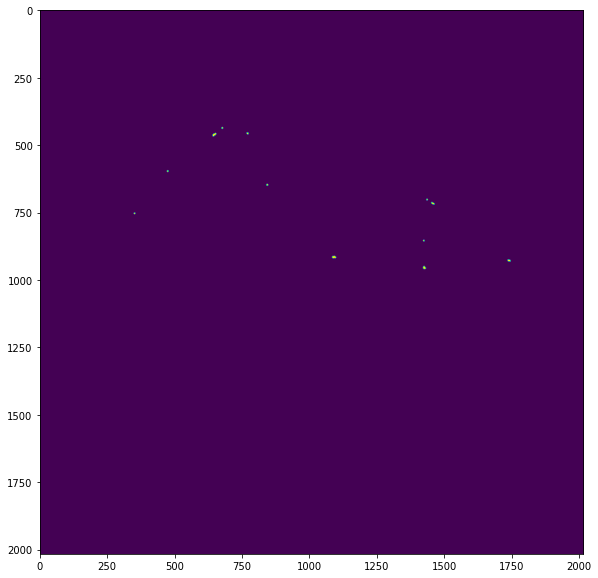

In [177]:
mer_err_map_closed = morphology.binary_closing(image = mer_err_map, footprint = footprint)
mer_err_map_2 = np.minimum(mer_err_map_closed, sub_closed_error_map)
footprint = disk(3)
mer2_opened_error_map = morphology.binary_opening(image = mer_err_map_2, footprint = footprint)
plt.imshow(mer2_opened_error_map)                    

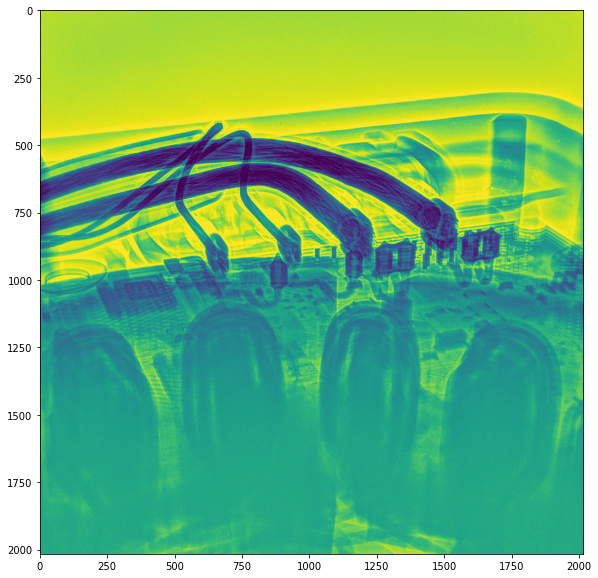

In [164]:
plt.imshow(img_array_nok_0206[2, :, :])

In [162]:
heatmap(img_array_nok_0206[2:3, :, :], mer_opened_error_map.reshape(1, 2016,2016).astype('bool'))

C:\Users\timob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


AttributeError: 'bool' object has no attribute 'all'

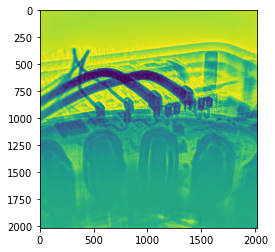

In [132]:
plt.imshow(rRecon.reconstruct(img_array_nok_0206[0, :, :]) - )

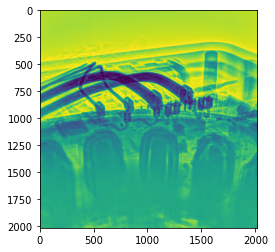

In [123]:
plt.imshow(cRecon.reconstruct(img_array_ok_0206[0, :, :]))